In [197]:
import torch
import torch.nn.functional as F;
import matplotlib.pyplot as plt;
%matplotlib inline


In [198]:
words = open("Data/SortedLowercase.txt",'r').read().splitlines()
words[:8]

['աբգար', 'աբեթ', 'աբել', 'աբիկ', 'աբիկ', 'աբով', 'աբրահամ', 'աբրամ']

In [199]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'ա', 2: 'բ', 3: 'գ', 4: 'դ', 5: 'ե', 6: 'զ', 7: 'է', 8: 'ը', 9: 'թ', 10: 'ժ', 11: 'ի', 12: 'լ', 13: 'խ', 14: 'ծ', 15: 'կ', 16: 'հ', 17: 'ձ', 18: 'ղ', 19: 'ճ', 20: 'մ', 21: 'յ', 22: 'ն', 23: 'շ', 24: 'ո', 25: 'չ', 26: 'պ', 27: 'ջ', 28: 'ռ', 29: 'ս', 30: 'վ', 31: 'տ', 32: 'ր', 33: 'ց', 34: 'ւ', 35: 'փ', 36: 'ք', 37: 'օ', 38: 'ֆ', 0: '.'}


In [200]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([12511, 3]) torch.Size([12511])
torch.Size([1583, 3]) torch.Size([1583])
torch.Size([1563, 3]) torch.Size([1563])


In [201]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((39, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 39), generator=g)
b2 = torch.randn(39, generator=g)
parameters = [C, W1, b1, W2, b2]

In [202]:
sum(p.nelement() for p in parameters) # number of parameters in total

14429

In [203]:
for p in parameters:
  p.requires_grad = True

In [204]:
lre = torch.linspace(-3, 0, 10000)
lrs = 10**lre

In [205]:
lri = []
lossi = []
stepi = []

In [206]:
for i in range(50000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.item())

#print(loss.item())

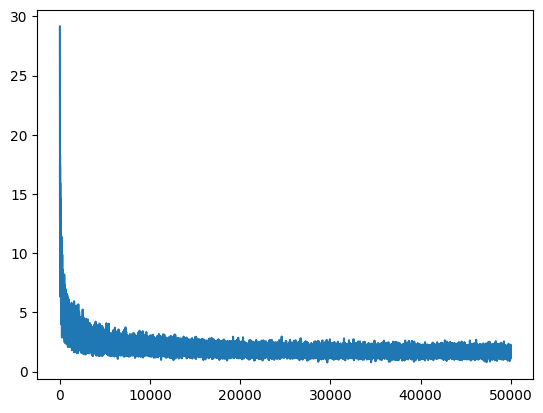

In [209]:
plt.plot(stepi, lossi)

In [210]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.6431, grad_fn=<NllLossBackward0>)

In [211]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.8459, grad_fn=<NllLossBackward0>)

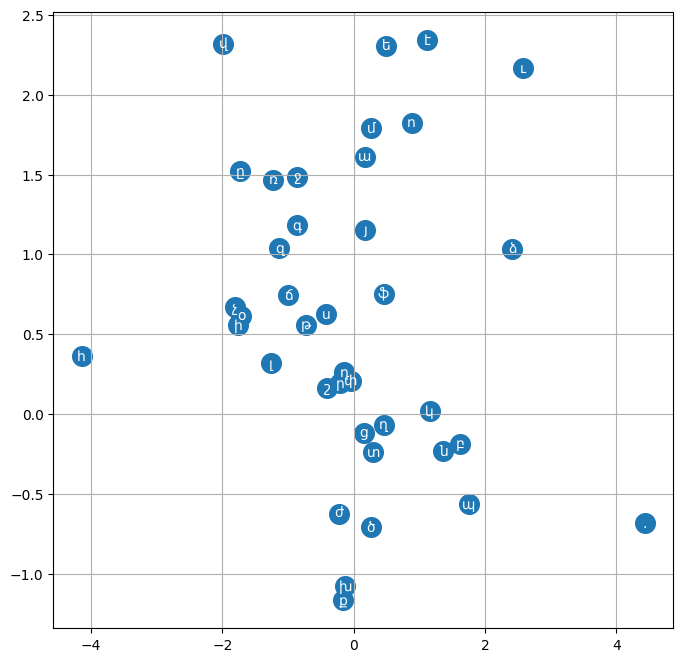

In [212]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [214]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [215]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(50):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

գարունիք.
նազարմինէ.
շարմուէլ.
թամաս.
երւան.
մանի.
վահատ.
մինէ.
ստելլոս.
լուստ.
մանիկ.
սիս.
անդյլգա.
սահանոս.
անա.
փառի.
սին.
շողական.
ճգնաւ.
նաիրուան.
ասպարսիկ.
խաչում.
վան.
արզա.
զամ.
գալ.
սաթու.
բար.
օնիկ.
ձայիս.
նաիրնուշ.
արշի.
անդրաս.
դրիկ.
նան.
մարգին.
ալաքարոլակ.
սիա.
յասօ.
թալիրանիշել.
լամ.
լուս.
ատոմ.
յաւօ.
անանի.
գին.
ամիս.
արա.
հուր.
քաջանիկ.
